In [1]:
import taichi as ti
import numpy as np
import napari
import matplotlib.pyplot as plt
from simulation import Simulation

[Taichi] version 1.7.4, llvm 15.0.1, commit b4b956fd, win, python 3.11.5


In [2]:
N = 128
wavelengths = [0.75, 0.55, 0.45]
N_PHOTONS = 100000000
BATCH_SIZE = 50000000
N_TRACKED = 100

types = [
    {"name": "cell1", "rel_scale": 5, "rel_density": 20, "rel_pigment": 1E-10, "r_index": 0.5},
    {"name": "cell2", "rel_scale": 1, "rel_density": 5, "rel_pigment": 5E-11, "r_index": 0.5},
    {"name": "cell3", "rel_scale": 1, "rel_density": 2.5, "rel_pigment": 25E-12, "r_index": 0.5}
]

faces = ["+x", "+y", "-z"]

# Store images from each wavelength
# Structure: images[face_idx][wavelength_idx] = image
images = {face: [] for face in faces}

viewer = napari.Viewer(title="3D Test Volume", ndisplay=3)

In [3]:
for wavelength in wavelengths:
    runner = Simulation(N=N, wavelength=wavelength, n_photons=N_PHOTONS, batch_size=BATCH_SIZE)
    runner.init_types(types, scatter_prec=10000)

    runner.organoidGen([64, 64, 64], [45, 18, 18], [1, 0.5, 0], [0, 1, 0], 0, 0.5, 0.1)

    
    central_point = (64, 64, 64)  # Target at origin
    distance = np.sqrt(2)*64+1  # Source 10 units away
    theta = 0
    phi = np.pi/2
    mask_diameter = 1.5*np.sqrt(128**2)
    sigma_a = 256
    sigma_b = 256
    divergence_a = -0.02
    divergence_b = -0.02         # why is this sign reversed?
    divergence_sigma_a = 0.005
    divergence_sigma_b = 0.005

    MAX_STEPS = round(distance * 10)
    STEP_LENGTH = 0.5

    runner.init_beam_generator(central_point, distance, theta, phi, mask_diameter, sigma_a, sigma_b, divergence_a, divergence_b, divergence_sigma_a, divergence_sigma_b)

    for face in faces:
        runner.init_microscope(face, N, 1.0, 0.15, 1, 1.33, (N, N), 1.0, wavelength * 1000, 64.0)

    TRACK = True
    runner.simulation_loop(MAX_STEPS, STEP_LENGTH, TRACK, N_TRACKED)

    # Collect images from each face
    for i, face in enumerate(faces):
        image_defocus = runner.defocus_image(i)
        images[face].append(image_defocus)
        print(f"Wavelength {wavelength} μm, Face {face}: intensity range [{image_defocus.min():.2e}, {image_defocus.max():.2e}]")


[Taichi] Starting on arch=cuda
Taichi Microscope with Defocus initialized:
  Observation face: +x
  Focal depth: 64.0 voxels (64.0 μm)
  Depth of field: 16.67 μm (16.67 voxels)
  NA: 0.15, Acceptance angle: 6.5°
  Min sigma (in-focus): 1.30 pixels
Taichi Microscope with Defocus initialized:
  Observation face: +y
  Focal depth: 64.0 voxels (64.0 μm)
  Depth of field: 16.67 μm (16.67 voxels)
  NA: 0.15, Acceptance angle: 6.5°
  Min sigma (in-focus): 1.30 pixels
Taichi Microscope with Defocus initialized:
  Observation face: -z
  Focal depth: 64.0 voxels (64.0 μm)
  Depth of field: 16.67 μm (16.67 voxels)
  NA: 0.15, Acceptance angle: 6.5°
  Min sigma (in-focus): 1.30 pixels
Loop 1 (100000000 photons remaining):
Running 50000000 photons

Adding photons to microscope 0 (+x):
Face +x: 1083315 photons at face, 4347 within NA
  Unscattered photons: 0 (0.0%)
  Sigma range: [1.30, 2.53] pixels
  Accumulated peak intensity: 4.55e-02

Adding photons to microscope 1 (+y):
Face +y: 1156894 photons


Face +x:
  R channel (0.75μm) max: 8.91e-02
  G channel (0.55μm) max: 1.32e-01
  B channel (0.45μm) max: 1.42e-01

Face +y:
  R channel (0.75μm) max: 9.91e-02
  G channel (0.55μm) max: 1.42e-01
  B channel (0.45μm) max: 1.72e-01

Face -z:
  R channel (0.75μm) max: 3.68e+01
  G channel (0.55μm) max: 3.70e+01
  B channel (0.45μm) max: 3.72e+01


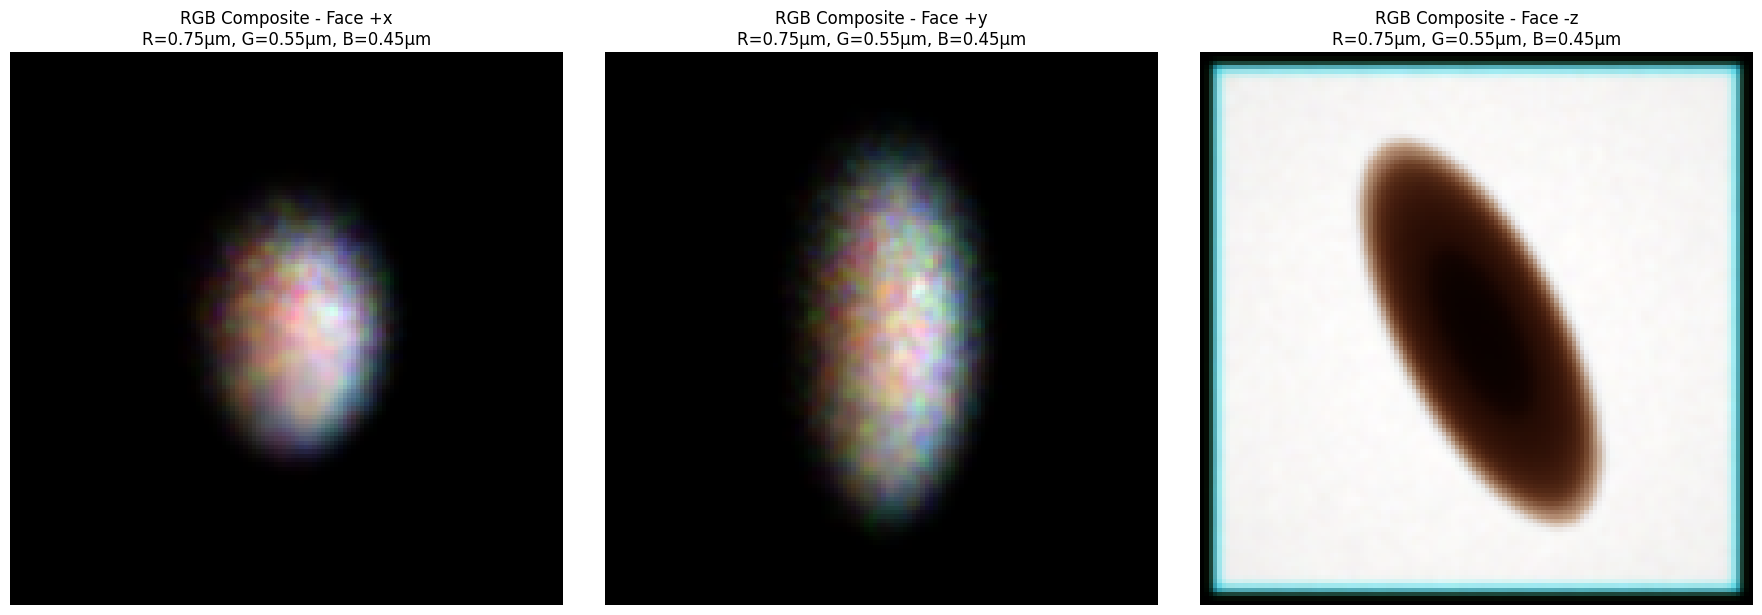


✓ RGB composites added to napari viewer and displayed in notebook


In [4]:
# Create RGB composite images for each face and display in notebook
# R = wavelength[0] (0.75 μm - red)
# G = wavelength[1] (0.55 μm - green)  
# B = wavelength[2] (0.45 μm - blue)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, face in enumerate(faces):
    # Get images for this face from all wavelengths
    r_img = images[face][0]  # 0.75 μm
    g_img = images[face][1]  # 0.55 μm
    b_img = images[face][2]  # 0.45 μm
    
    # Normalize each channel to [0, 1]
    r_norm = r_img / r_img.max() if r_img.max() > 0 else r_img
    g_norm = g_img / g_img.max() if g_img.max() > 0 else g_img
    b_norm = b_img / b_img.max() if b_img.max() > 0 else b_img
    
    # Stack into RGB image: shape (H, W, 3)
    rgb_image = np.stack([r_norm, g_norm, b_norm], axis=-1)
    
    # Display in notebook
    axes[idx].imshow(rgb_image)
    axes[idx].set_title(f'RGB Composite - Face {face}\nR=0.75μm, G=0.55μm, B=0.45μm', fontsize=12)
    axes[idx].axis('off')
    
    print(f"\nFace {face}:")
    print(f"  R channel (0.75μm) max: {r_img.max():.2e}")
    print(f"  G channel (0.55μm) max: {g_img.max():.2e}")
    print(f"  B channel (0.45μm) max: {b_img.max():.2e}")

plt.tight_layout()
plt.show()

# Also add to napari viewer as planes (optional - may show as grayscale)
for face in faces:
    # Get images for this face from all wavelengths
    r_img = images[face][0]
    g_img = images[face][1]
    b_img = images[face][2]
    
    # Normalize each channel to [0, 1]
    r_norm = r_img / r_img.max() if r_img.max() > 0 else r_img
    g_norm = g_img / g_img.max() if g_img.max() > 0 else g_img
    b_norm = b_img / b_img.max() if b_img.max() > 0 else b_img
    
    # Stack into RGB image: shape (H, W, 3)
    rgb_image = np.stack([r_norm, g_norm, b_norm], axis=-1)
    
    # Map observation face to plane position and normal
    face_config = {
        '+z': {'position': (N/2, N/2, 0), 'normal': (0, 0, -1)},
        '-z': {'position': (N/2, N/2, 0), 'normal': (0, 0, 1)},
        '+x': {'position': (0, N/2, N/2), 'normal': (1, 0, 0)},
        '-x': {'position': (0, N/2, N/2), 'normal': (1, 0, 0)},
        '+y': {'position': (N/2, 0, N/2), 'normal': (0, -1, 0)},
        '-y': {'position': (N/2, 0, N/2), 'normal': (0, 1, 0)},
    }
    
    config = face_config[face]
    
    # Reshape RGB image to 3D for plane rendering
    if face in ['+x', '-x']:
        # x-face: image is in yz plane, RGB becomes (1, Y, Z, 3)
        rgb_3d = rgb_image[np.newaxis, :, :, :]
    elif face in ['+z', '-z']:
        # z-face: image is in xy plane, RGB becomes (Y, X, 1, 3)
        rgb_3d = rgb_image[:, :, np.newaxis, :]
    elif face in ['+y', '-y']:
        # y-face: image is in xz plane, RGB becomes (X, 1, Z, 3)
        rgb_3d = rgb_image[:, np.newaxis, :, :]
    
    viewer.add_image(
        rgb_3d,
        name=f'RGB Composite ({face})',
        rgb=True,
        rendering='average',
        depiction='plane',
        blending='translucent',
        opacity=1.0,
        plane={
            'position': config['position'],
            'normal': config['normal']
        }
    )

print("\n✓ RGB composites added to napari viewer and displayed in notebook")